# Christmas in Asheville

All questions are relative to AirBnB listings in the city of Asheville, NC over the "Christmas at Biltmore" dates (https://www.biltmore.com/things-to-do/events/christmas/) for 2019 (6 November, 2019 through 10 January, 2020) and 2020 (8 November 2020, through 12 January 2021). Only "entire" properties with at most 3-night minimums are considered. We're typically interested in properties that will hold a family, so no smaller properties (e.g., guest room).  We'll also limit the properties to rents prices of less than \\$900 per night and less than \\$250 per maximum occupant.

All data is obtained from the InsideAirBnB (http://insideairbnb.com) web site for Asheville, North Carolina, United States.  Data from the 24 October, 2020 and 27 October, 2019 compilation dates were used for this study.

The questions I'll attempt to answer include:
* How many properties are listed by neighborhood year over year?
* What is the average rental price of the listed properties listed by neighborhood year over year?
* What is the average rental price per maximum occupancy of the properties listed by neighborhood year over year?
* How has the relative availability changed over the given time period for each of the neighborhoods year over year?
* Did the most influential factors that determine price change year over year?

The results are intended to provide an exploratory analysis of how the Christmas-time rental landscape prior to the Covid-19 pandemic and during the pandemic.  

Steps included in this notebook:
1. Load appropriate libraries
2. Gather necessary data  
    a. Neighborhood data  
    b. Calendar data  
    c. Listings data  
3. Prepare, Assess, and Analyze data  
    a. Exploration and visualization  
    b. Regression  



## 1. Load appropriate libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import plotly.express as px
import folium

from sklearn.linear_model import LinearRegression

import seaborn as sns
%matplotlib inline

## 2. Gather appropriate data - neighborhoods

The folium package was used to map the neighborhoos using the supplied GeoJson file

In [50]:
# Note that the 27 October, 2020 neighborhood data was used for this notebook.
with open('../data/neighbourhoods.geojson') as f:
    geo_neighborhoods = json.load(f)

# Use folium to map the neighborhoods
tiles = ['OpenStreetMap', 'Stamen Terrain', 'Stamen Toner', 'Mapbox Bright', 'Mapbox Control Room']
m = folium.Map(location=[35.55, -82.55],
               zoom_start=11,
               tiles=tiles[1]
              )
folium.GeoJson(geo_neighborhoods, 
               name="geo_neighborhoods", 
               tooltip=folium.features.GeoJsonTooltip(fields=["neighbourhood"])
               #tooltip=folium.features.GeoJsonTooltip(fields=list(geo_neighborhood_codes['code']))
              ).add_to(m)
m.save("../results/Asheville-NHcodes.html")
m




Notice that the GeoJson file only includes neighborhood codes.  So, let's add some descriptive names to the codes to at least give a geogrpahical descriptions of the neighborhood.  So that folium will display the names on the map, let's add the names to the json data structure as well.

I've also included some location markers to the map to highlight points of interest.

In [52]:
# create geographical names
neighborhood_lookup = pd.DataFrame({'code': ['28704','28715','28732','28801','28803','28804','28805','28806'],
                                    'name': ['South','West','Southeast','Downtown','Biltmore Forest','North','Northeast','Northwest']},
                                  )

geo_neighborhood_codes = pd.DataFrame({'code':[x['properties']['neighbourhood'] for x in geo_neighborhoods['features']]}).merge(neighborhood_lookup)

# also add integer versions of the codes.  this will be useful later when joining the map to the listings data
geo_neighborhood_codes['code_int'] = geo_neighborhood_codes['code'].astype(int)

print(geo_neighborhood_codes)

# add the neighborhood names to the GeoJson-based structure
for i in range(len(geo_neighborhoods['features'])):
    geo_neighborhoods['features'][i]['properties']['neighborhood'] = geo_neighborhood_codes.iloc[i]['name'] + ' (' + geo_neighborhood_codes.iloc[i]['code'] + ')'


    code             name  code_int
0  28806        Northwest     28806
1  28805        Northeast     28805
2  28804            North     28804
3  28803  Biltmore Forest     28803
4  28801         Downtown     28801
5  28715             West     28715
6  28704            South     28704
7  28732        Southeast     28732


In [53]:
tiles = ['OpenStreetMap', 'Stamen Terrain', 'Stamen Toner', 'Mapbox Bright', 'Mapbox Control Room']
m = folium.Map(location=[35.55, -82.55],
               zoom_start=10,
               tiles=tiles[1]
              )
folium.Marker([35.5406, -82.5523], tooltip="<i>Biltmore Estate<i>"
    ).add_to(m)
folium.Marker([35.4328, -82.2505], tooltip="<i>Chimney Rock<i>"
    ).add_to(m)
folium.Marker([35.5948, -82.5515], tooltip="<i>Asheville Urban Trail<i>"
    ).add_to(m)
folium.Marker([35.2847, -82.7270], tooltip="<i>Pisgah National Forest<i>"
    ).add_to(m)
folium.Marker([35.5649, -82.4876], tooltip="<i>Blue Ridge Parkway<i>"
    ).add_to(m)
folium.Marker([35.4959, -82.6052], tooltip="<i>North Carolina Arboretum<i>"
    ).add_to(m)

folium.GeoJson(geo_neighborhoods, 
               name="geo_neighborhoods", 
               tooltip=folium.features.GeoJsonTooltip(fields=["neighborhood"])
              ).add_to(m)
m.save("../results/Asheville-NHNames.html")
m

## 2. Gather appropriate data - calendar

This step, along with the listings step, will simply load the raw data and inspect the contents.  Modifications as a result of the inspection will be identified but handled at a later step.

In [5]:
df_calendar_2020 = pd.read_csv('../data/calendar_Asheville_202010.csv')
df_calendar_2019 = pd.read_csv('../data/calendar_Asheville_201910.csv')

In [6]:
print(df_calendar_2020.head())
print(df_calendar_2019.head())

   listing_id        date available   price adjusted_price  minimum_nights  \
0     7938930  2020-10-24         f  $50.00         $50.00              30   
1      108061  2020-10-24         f  $80.00         $80.00              30   
2      108061  2020-10-25         f  $80.00         $80.00              30   
3      108061  2020-10-26         f  $80.00         $80.00              30   
4      108061  2020-10-27         f  $80.00         $80.00              30   

   maximum_nights  
0             120  
1            1125  
2            1125  
3            1125  
4            1125  
   listing_id        date available    price adjusted_price  minimum_nights  \
0     2708104  2019-10-27         f  $139.00        $139.00               1   
1       38585  2019-10-27         f   $65.00         $65.00               2   
2       38585  2019-10-28         f   $65.00         $65.00               2   
3       38585  2019-10-29         f   $65.00         $65.00               2   
4       38585  2

In [7]:
print(df_calendar_2020.info())
print(df_calendar_2019.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766135 entries, 0 to 766134
Data columns (total 7 columns):
listing_id        766135 non-null int64
date              766135 non-null object
available         766135 non-null object
price             766135 non-null object
adjusted_price    766135 non-null object
minimum_nights    766135 non-null int64
maximum_nights    766135 non-null int64
dtypes: int64(3), object(4)
memory usage: 40.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880015 entries, 0 to 880014
Data columns (total 7 columns):
listing_id        880015 non-null int64
date              880015 non-null object
available         880015 non-null object
price             880015 non-null object
adjusted_price    880015 non-null object
minimum_nights    880015 non-null int64
maximum_nights    880015 non-null int64
dtypes: int64(3), object(4)
memory usage: 47.0+ MB
None


There are no null values in either table.  The 'available' column will be converted to boolean so that values can be handled numerically.  The two price columns will need to be converted to numeric.

The data will be limited by the "Christmas at Biltmore" dates.  Also, since we're only interested in average values, the data will be converted to aggregate data for each listing and then joined to the appropiate listing

## 2. Gather important data - listings

In this step, we'll inspect a few of the columns to determine if any values that we want to keep for the study.  Recall that we are only looking at "entire" properties

In [8]:
#df_listings_full_2020 = create_df('calendar_Asheville_202010.csv', 'listings_Asheville_202010.csv', '2020-11-06', '2021-01-10')
#df_listings_full_2019 = create_df('calendar_Asheville_201910.csv', 'listings_Asheville_201910.csv', '2019-11-08', '2020-01-12')

df_listings_2020 = pd.read_csv('../data/listings_Asheville_202010.csv')
df_listings_2019 = pd.read_csv('../data/listings_Asheville_201910.csv')

In [9]:
print(df_listings_2020.info())
#print(df_listings_2019.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099 entries, 0 to 2098
Data columns (total 74 columns):
id                                              2099 non-null int64
listing_url                                     2099 non-null object
scrape_id                                       2099 non-null int64
last_scraped                                    2099 non-null object
name                                            2099 non-null object
description                                     2094 non-null object
neighborhood_overview                           1703 non-null object
picture_url                                     2099 non-null object
host_id                                         2099 non-null int64
host_url                                        2099 non-null object
host_name                                       2099 non-null object
host_since                                      2099 non-null object
host_location                                   2097 non-null object

Since we are only interested in "entire" properties, let's examine the room_type and property_type columns.

In [10]:
print(df_listings_2020['room_type'].value_counts())
print(df_listings_2019['room_type'].value_counts())

Entire home/apt    1678
Private room        394
Hotel room           19
Shared room           8
Name: room_type, dtype: int64
Entire home/apt    1803
Private room        580
Hotel room           19
Shared room           9
Name: room_type, dtype: int64


The room_type variable has similar values for each data set.  Since we're only interested in renting the "entire" property, we'll just keep those room types.

Looking at property type through this filter ...

In [11]:
print(df_listings_2020[df_listings_2020['room_type']=='Entire home/apt']['property_type'].value_counts())
print(df_listings_2019[df_listings_2019['room_type']=='Entire home/apt']['property_type'].value_counts())

Entire house          581
Entire apartment      324
Entire guest suite    273
Entire condominium    104
Entire guesthouse      80
Entire cabin           68
Entire cottage         67
Entire bungalow        66
Entire townhouse       34
Entire loft            24
Tiny house             17
Campsite               12
Entire chalet           9
Camper/RV               5
Yurt                    5
Farm stay               4
Tent                    2
Entire place            1
Treehouse               1
Hut                     1
Name: property_type, dtype: int64
House          623
Apartment      354
Guest suite    288
Guesthouse      91
Condominium     89
Bungalow        86
Cottage         74
Cabin           66
Townhouse       28
Loft            26
Other           17
Tiny house      15
Chalet          14
Camper/RV       11
Campsite         8
Yurt             5
Farm stay        4
Tent             2
Treehouse        1
Aparthotel       1
Name: property_type, dtype: int64


From these lists, we can see that properties are listed differently.  We'll change the 'Entire \*' listings in the 2020 data  set to match the '\*' values in the 2019 data and limit the property types to 'House', 'Apartment', 'Guest suite', 'Condominium', 'Guesthouse', 'Cottage', 'Cabin', 'Bungalow', 'Townhouse', 'Loft', 'Chalet', and 'Tiny house'.


Next, we'll look at the bathroom columns (bathrooms, bathrooms_text)

In [12]:
print(df_listings_2020[['bathrooms','bathrooms_text']])
print(df_listings_2019[['bathrooms']]) # bathrooms_text doesn't exist in the 2020 set

      bathrooms    bathrooms_text
0           NaN            1 bath
1           NaN            1 bath
2           NaN  2.5 shared baths
3           NaN            1 bath
4           NaN            1 bath
...         ...               ...
2094        NaN            1 bath
2095        NaN     1 shared bath
2096        NaN    1 private bath
2097        NaN         1.5 baths
2098        NaN         1.5 baths

[2099 rows x 2 columns]
      bathrooms
0           1.0
1           2.0
2           1.0
3           1.0
4           2.5
...         ...
2406        1.0
2407        1.0
2408        1.0
2409        2.0
2410        1.5

[2411 rows x 1 columns]


Since the 2020 data set lists the number of bathrooms in the 'bathrooms_text' field, we'll convert it to a number and map it to the 'bathrooms' field.

## 3. Prepare, Assess, and Analyze data - exploration and visualization

The function below makes the changes listed above including the limits on the data.  The geographical, calendar, and listings data are combined into one data set for exploration.  Further changes will be made (e.g., null handling, dummies) to the data later for analysis.

In [13]:
def create_df(df_calendar, df_listings, min_date, max_date):
    '''
    INPUT:
    df_calendar - pandas dataframe with calendar-based data for AirBnB listings
    df_listings - pandas dataframe with listings-based date for AirBnB listings
    min_date - earliest calendar date to retain from calendar data frame
    max_date - latest calendar date to retain from calendar data frame
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. aggregated data grouped by listing and within the min_date and max_date from the calendar data frame
            2. associated listing attributes from the listing data frame
            3. standardized property types and limited to certain property types
            4. records with a maximum minimum_nights of 3
            5. records with a maximum average price of $900
            6. records with a maximum average price per accomodation of $250
            7. cleaned 'bathrooms' (ha!) column, i.e., no bathroom_text column
            8. 'host_is_superhost' and 'instant_bookable' columns modified from t/f to 1/0 values
    '''
    
    
    # first need to convert the object columns to date or numeric
    df_calendar['date'] = pd.to_datetime(df_calendar['date'])
    df_calendar['available'] = df_calendar['available'].str.upper() == 'T'
    df_calendar['price'] = df_calendar['price'].str.replace(',', '').str.split('$').str[1].astype('float')
    df_calendar['adjusted_price'] = df_calendar['adjusted_price'].str.replace(',', '').str.split('$').str[1].astype('float')
    
    # keep only dates within the min_date and max_date
    df_calendar = df_calendar[(df_calendar['date'] >= min_date) & (df_calendar['date'] <= max_date)]
    
    # group by listing id and generate metrics
    df_calendar_group = df_calendar.groupby('listing_id').agg({'date':[np.min, np.max], 
                                                           'available':[np.sum,np.mean],
                                                           'price':[np.mean], 
                                                           'adjusted_price':[np.mean], 
                                                           'minimum_nights':[np.min]})
    df_calendar_group.columns = ['date_min','date_max','available','available_avg','price_avg','adjusted_price_avg','min_nights_min']
    
    # merge the neighborhood codes to the listings
    df_listings = geo_neighborhood_codes.merge(df_listings, 
                                               left_on='code_int', 
                                               right_on='neighbourhood_cleansed').rename(columns={'name_x': 'neighborhood_name'}).drop(columns=['code','code_int'])

    
    # inner join on listing id
    df_listings = pd.merge(df_calendar_group, df_listings, left_index=True, right_on="id").reset_index()
    
    # create a new column for average price per accommodation
    df_listings["price_avg_per_accomm"] = df_listings["price_avg"] / df_listings["accommodates"]
    df_listings["adjusted_price_avg_per_accomm"] = df_listings["adjusted_price_avg"] / df_listings["accommodates"]
    
    # keep only room_types that are 'entire'
    df_listings = df_listings[df_listings["room_type"]=="Entire home/apt"]

    # remove 'Entire ' from certain property types
    df_listings['property_type'].replace({'Entire house': 'House',
                            'Entire apartment': 'Apartment',
                            'Entire guest suite': 'Guest suite',
                            'Entire condominium': 'Condominium',
                            'Entire guesthouse': 'Guesthouse',
                            'Entire cottage': 'Cottage',
                            'Entire cabin': 'Cabin',
                            'Entire bungalow': 'Bungalow',
                            'Entire townhouse': 'Townhouse',
                            'Entire loft': 'Loft',
                            'Entire chalet': 'Chalet'},
                                        inplace=True)
    
    # Not sure if I want to rent any of a treehouse or a tent or a bus, so let's define the valid propert types
    valid_property_types = ['House',
                            'Apartment',
                            'Guest suite',
                            'Condominium',
                            'Guesthouse',
                            'Cottage',
                            'Cabin',
                            'Bungalow',
                            'Townhouse',
                            'Loft',
                            'Chalet',
                            'Tiny house']
    
    #(df_listings["property_type"].str.startswith("Entire")) | (df_listings["property_type"]=="Tiny house")
    df_listings = df_listings[df_listings["property_type"].isin(valid_property_types)]
    
    # I don't want to have to rent more than three nights so let's filter out the 4 night and up minimums
    df_listings = df_listings[df_listings["minimum_nights"] <= 3]

    # keep only listings where the average price is less than $1000
    df_listings = df_listings[df_listings['price_avg'] < 900]
    
    # keep only listings where the price_avg_per_accomm is less than $250
    df_listings = df_listings[df_listings['price_avg_per_accomm'] < 250]
    
    df_listings = df_listings.reset_index()
    
    # handle the bathrooms column
    # if the bathroom column is all null then the bathroom_text column exists
    if df_listings['bathrooms'].isnull().all():
        #split the bathroom_text column by a space and keep the first element
        bathroom_split = df_listings['bathrooms_text'].str.split(' ')
        df_listings['bathrooms'] = bathroom_split.str[0].astype('float')
        
    # change the 't' and 'f' in host_is_superhost to 1 and 0.  convert the column to an integer
    df_listings['host_is_superhost'] = df_listings['host_is_superhost'].apply(lambda x: '1' if x == 't' else '0').astype(int)
    
    # same with instant_bookable
    df_listings['instant_bookable'] = df_listings['instant_bookable'].apply(lambda x: '1' if x == 't' else '0').astype(int)

    # return the data frame
    return (df_listings)


In [14]:
df_listings_full_2020 = create_df(df_calendar_2020, df_listings_2020, '2020-11-06', '2021-01-10')
df_listings_full_2020


,level_0,index,date_min,date_max,available,available_avg,price_avg,adjusted_price_avg,min_nights_min,neighborhood_name,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_avg_per_accomm,adjusted_price_avg_per_accomm
0,1,0,2020-11-06,2021-01-10,47.0,0.712121,91.393939,91.393939,1,Northwest,...,10.0,NaN,1,6,1,1,4,2.41,45.696970,45.696970
1,11,1051,2020-11-06,2021-01-10,54.0,0.818182,125.000000,125.000000,2,Biltmore Forest,...,10.0,NaN,0,1,1,0,0,0.41,62.500000,62.500000
2,12,1342,2020-11-06,2021-01-10,4.0,0.060606,120.242424,120.242424,3,Downtown,...,10.0,NaN,1,3,3,0,0,2.90,40.080808,40.080808
3,13,1052,2020-11-06,2021-01-10,22.0,0.333333,135.257576,135.257576,2,Biltmore Forest,...,NaN,NaN,1,1,1,0,0,6.45,45.085859,45.085859
4,17,4,2020-11-06,2021-01-10,41.0,0.621212,74.378788,74.378788,2,Northwest,...,10.0,NaN,0,1,1,0,0,1.84,18.594697,18.594697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,2086,1336,2020-11-06,2021-01-10,11.0,0.166667,484.166667,484.166667,2,Biltmore Forest,...,NaN,NaN,1,26,26,0,0,NaN,53.796296,53.796296
1400,2087,1048,2020-11-06,2021-01-10,50.0,0.757576,256.818182,256.818182,2,North,...,10.0,NaN,0,1,1,0,0,1.00,128.409091,128.409091
1401,2088,788,2020-11-06,2021-01-10,8.0,0.121212,140.378788,140.378788,2,Northeast,...,NaN,NaN,1,1,1,0,0,NaN,35.094697,35.094697
1402,2093,1338,2020-11-06,2021-01-10,27.0,0.409091,191.121212,191.121212,2,Biltmore Forest,...,NaN,NaN,0,5,5,0,0,NaN,23.890152,23.890152


In [15]:
df_listings_full_2019 = create_df(df_calendar_2019, df_listings_2019, '2019-11-08', '2020-01-12')
df_listings_full_2019


,level_0,index,date_min,date_max,available,available_avg,price_avg,adjusted_price_avg,min_nights_min,neighborhood_name,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_avg_per_accomm,adjusted_price_avg_per_accomm
0,1,1586,2019-11-08,2020-01-12,62.0,0.939394,593.227273,593.227273,1,Downtown,...,super_strict_60,f,f,10,10,0,0,1.01,49.435606,49.435606
1,3,0,2019-11-08,2020-01-12,45.0,0.681818,81.121212,81.121212,1,Northwest,...,moderate,f,f,7,1,2,4,2.21,40.560606,40.560606
2,11,693,2019-11-08,2020-01-12,30.0,0.454545,75.590909,75.590909,2,Northeast,...,moderate,f,f,2,2,0,0,5.19,37.795455,37.795455
3,14,4,2019-11-08,2020-01-12,41.0,0.621212,78.121212,78.121212,1,Northwest,...,moderate,f,t,1,1,0,0,6.44,19.530303,19.530303
4,15,1249,2019-11-08,2020-01-12,49.0,0.742424,125.000000,125.000000,2,Biltmore Forest,...,moderate,f,f,1,1,0,0,0.40,62.500000,62.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,2405,2410,2019-11-08,2020-01-12,60.0,0.909091,100.000000,100.000000,2,Southeast,...,flexible,f,f,1,1,0,0,NaN,25.000000,25.000000
1544,2406,955,2019-11-08,2020-01-12,49.0,0.742424,55.000000,55.000000,1,Northeast,...,moderate,f,f,2,2,0,0,NaN,27.500000,27.500000
1545,2407,691,2019-11-08,2020-01-12,57.0,0.863636,63.742424,63.742424,1,Northwest,...,flexible,f,f,1,1,0,0,NaN,31.871212,31.871212
1546,2408,2220,2019-11-08,2020-01-12,66.0,1.000000,125.000000,125.000000,2,West,...,flexible,f,f,1,1,0,0,NaN,41.666667,41.666667


### How many properties are listed by neighborhood year over year?

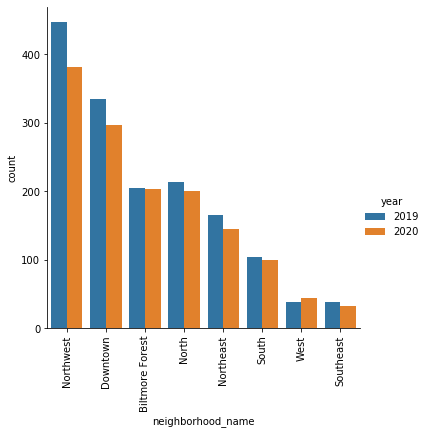

In [16]:
df_yearly_neighborhood_property_count = pd.concat(
    [df_listings_full_2020['neighborhood_name'].value_counts().to_frame().assign(year=2020),
     df_listings_full_2019['neighborhood_name'].value_counts().to_frame().assign(year=2019)]
).reset_index()
df_yearly_neighborhood_property_count.rename(columns={'neighborhood_name': 'count',
                                              'index': 'neighborhood_name'},
                                            inplace=True)

#df_yearly_neighborhood_property_count
g = sns.catplot(x='neighborhood_name', y='count', hue='year', data=df_yearly_neighborhood_property_count, kind="bar")
g.set_xticklabels(rotation=90);


In almost all neighborhoods, the number of listed properties decreased year over year.  It's probably safe to assume that it is pandemic related, but further research is necessary.

In [17]:
# keep the same order of neighborhoods in the following graphs for consistency
neighborhood_order = ['Northwest', 'Downtown', 'Biltmore Forest', 'North', 'Northeast', 'South', 'West', 'Southeast']

### What is the average rental price of the listed properties listed by neighborhood year over year?

In [18]:
df_yearly_neighborhood_price_avg = pd.concat(
    [df_listings_full_2020.assign(year=2020)[['year','neighborhood_name','price_avg', 'price_avg_per_accomm', 'available_avg']],
     df_listings_full_2019.assign(year=2019)[['year','neighborhood_name','price_avg', 'price_avg_per_accomm', 'available_avg']]]
    )

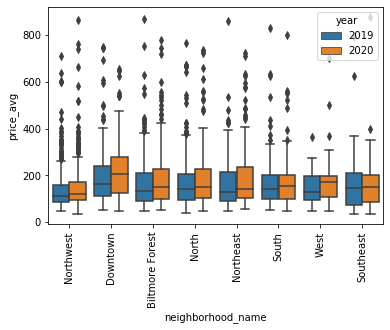

In [19]:
g=sns.boxplot(x='neighborhood_name', y='price_avg', hue='year', order=neighborhood_order, data=df_yearly_neighborhood_price_avg)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

While the number of rentable properties decreased, the average rental rate increased for all neighborhoods.  The IQR increased for most neighborhoods as well.

### What is the average rental price per maximum occupancy of the properties listed by neighborhood year over year?

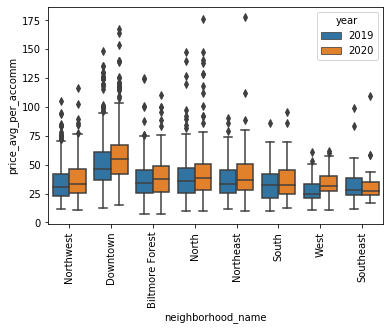

In [20]:
g=sns.boxplot(x='neighborhood_name', y='price_avg_per_accomm', hue='year', order=neighborhood_order, data=df_yearly_neighborhood_price_avg)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

Normalizing the rental rate via the maximum occupancy also shows an increase in rates as well.  

### How has the relative availability changed over the given time period for each of the neighborhoods year over year?
Did the most influential factors that determine price change year over year?

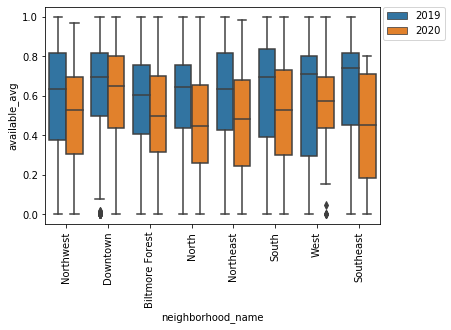

In [21]:
g=sns.boxplot(x='neighborhood_name', y='available_avg', hue='year', 
              order=neighborhood_order, data=df_yearly_neighborhood_price_avg)
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0);


Availability, which is defined by the percentage of dates available for a property as of the compilation date, went down on average year over year.  So, while the number of listed properties went down year over year, the relative demand (at least at Christmastime) went up from the previous year.  This is reflective in the availability and possibly in the increase in rental rates.  It's entirely possible that the supply decreased earlier in the year due to the pandemic and didn't come back toward the end of the year even as demand increased.  Further research is warranted.

## 3. Prepare and Analyze data - regression
Did the most influential factors that determine price change year over year?

To explore the factors that determine price, we first need to identify the columns of interest.  We'll use the ones listed below.  We will then need to determine what to do with the observations that contain null values.

In [22]:
regression_cols = ['price_avg','available_avg','neighborhood_name', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month'
       ]

In [23]:
# first see which columns contain null values
df_listings_full_2020[regression_cols].isnull().sum()

price_avg                        0
available_avg                    0
neighborhood_name                0
host_response_time              73
host_response_rate              73
host_acceptance_rate            42
host_is_superhost                0
property_type                    0
room_type                        0
accommodates                     0
bathrooms                        0
bedrooms                       117
beds                             0
number_of_reviews                0
number_of_reviews_ltm            0
review_scores_rating            43
review_scores_accuracy          70
review_scores_cleanliness       70
review_scores_checkin           70
review_scores_communication     70
review_scores_location          70
review_scores_value             70
instant_bookable                 0
reviews_per_month               42
dtype: int64

In [24]:
# first see which columns contain null values
df_listings_full_2019[regression_cols].isnull().sum()

price_avg                         0
available_avg                     0
neighborhood_name                 0
host_response_time               78
host_response_rate               78
host_acceptance_rate           1548
host_is_superhost                 0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
beds                              0
number_of_reviews                 0
number_of_reviews_ltm             0
review_scores_rating             76
review_scores_accuracy           76
review_scores_cleanliness        76
review_scores_checkin            76
review_scores_communication      76
review_scores_location           76
review_scores_value              76
instant_bookable                  0
reviews_per_month                76
dtype: int64

Let's first get rid of the host acceptance rate

In [25]:
regression_cols.remove('host_acceptance_rate')

Now look at the 'bedrooms'.  Looking at the scatterplot below, there is a relationship between the number of bathrooms and the number of bedrooms.  

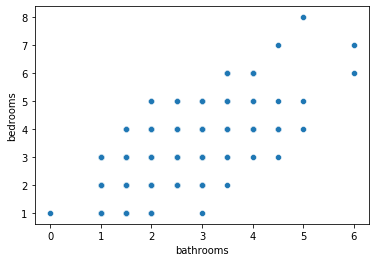

In [26]:
sns.scatterplot(x='bathrooms',y='bedrooms',data=df_listings_full_2020[['bathrooms','bedrooms']].dropna())

0.6410921828814895


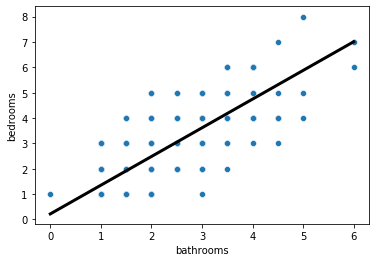

In [27]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
df_train = df_listings_full_2020[['bathrooms','bedrooms']].dropna()
X_train = np.array(df_train['bathrooms']).reshape(-1, 1)
y_train = np.array(df_train['bedrooms']).reshape(-1, 1)
reg.fit(X_train, y_train)
pred_space = np.linspace(min(X_train), max(X_train)).reshape(-1,1)
y_pred = reg.predict(pred_space)

# Print R^2 
print(reg.score(X_train, y_train))

# Plot regression line
sns.scatterplot(x='bathrooms',y='bedrooms',data=df_train)
plt.plot(pred_space, y_pred, color='black', linewidth=3)
plt.show()

#print([pred_space, y_pred])

From this, we can guess the number of bedrooms based on the number of bathrooms.

In [28]:
def guess_bedrooms(df):
    
    return_value = np.empty(shape=df.shape[0], dtype=float)
    
    for i in range(df.shape[0]):
        br=df.iloc[i]["bedrooms"]
        ba=df.iloc[i]["bathrooms"]
        if np.isnan(br):
            return_value[i] = reg.predict([[ba]])[0][0]
        else:
            return_value[i] = br
            
    return (return_value)

df_listings_full_2020["bedrooms"] = guess_bedrooms(df_listings_full_2020)
df_listings_full_2019["bedrooms"] = guess_bedrooms(df_listings_full_2019)


Now drop all of the null review score columns

In [29]:
# looking at the list of nulls, the one relate to review are probably all on the same rows
# lets removed the rows based on reviews_per_month and see
df_listings_full_2020.dropna(subset = ['review_scores_rating',
                                        'review_scores_accuracy',
                                        'review_scores_cleanliness',
                                        'review_scores_checkin',
                                        'review_scores_communication',
                                        'review_scores_location',
                                        'review_scores_value',
                                        'reviews_per_month'], inplace=True)
df_listings_full_2019.dropna(subset = ['review_scores_rating',
                                        'review_scores_accuracy',
                                        'review_scores_cleanliness',
                                        'review_scores_checkin',
                                        'review_scores_communication',
                                        'review_scores_location',
                                        'review_scores_value',
                                        'reviews_per_month'], inplace=True)


And then get rid of the null host response columns

In [30]:
# let's also drop the null host response rate and times
df_listings_full_2020.dropna(subset = ['host_response_time','host_response_rate'], inplace=True)
df_listings_full_2019.dropna(subset = ['host_response_time','host_response_rate'], inplace=True)

In [31]:
df_listings_full_2020[regression_cols].isnull().sum()

price_avg                      0
available_avg                  0
neighborhood_name              0
host_response_time             0
host_response_rate             0
host_is_superhost              0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
number_of_reviews              0
number_of_reviews_ltm          0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
instant_bookable               0
reviews_per_month              0
dtype: int64

In [32]:
df_listings_full_2019[regression_cols].isnull().sum()

price_avg                      0
available_avg                  0
neighborhood_name              0
host_response_time             0
host_response_rate             0
host_is_superhost              0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
number_of_reviews              0
number_of_reviews_ltm          0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
instant_bookable               0
reviews_per_month              0
dtype: int64

No more nulls

Now let's handle the categorical variables by using the function from the Udacity course to recreate the data frame with dummy variables in place of the categorical variables.

In [33]:
# use the function from the udacity course to create dummy columns from the categorical variables

def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

Create the new regression sets with the dummified categorical variables

In [34]:
df_listings_regression_2020 = create_dummy_df(df_listings_full_2020[regression_cols], 
                                              ['neighborhood_name','host_response_time','host_response_rate','property_type','room_type','instant_bookable'],
                                              False)

In [35]:
df_listings_regression_2019 = create_dummy_df(df_listings_full_2019[regression_cols], 
                                              ['neighborhood_name','host_response_time','host_response_rate','property_type','room_type','instant_bookable'],
                                              False)

In [36]:
# Get correlations between columns
corrs_2020 = df_listings_regression_2020.corr()#.sort_values("price_avg", ascending=False)
regression_cols_to_use = df_listings_regression_2020.columns
corrs_2019 = df_listings_regression_2019.corr()#.sort_values("price_avg", ascending=False)

## Plot correlations
#plt.subplots(figsize=(20,10))
#sns.set(font_scale=1)
#corr_plot = sns.heatmap(corrs_2020, yticklabels=regression_cols_to_use, xticklabels=regression_cols_to_use,
#                        cmap="OrRd", cbar=True, annot=True, square=True, fmt=".1f")
#corr_plot.set_title("Heatmap of Correlations Between Subset of Columns in Airbnb Asheville Data Set", fontsize=14);
#plt.tight_layout()

# Save plot
#corr_fig = corr_plot.get_figure()
#corr_fig.savefig('../results/correlations.png')

In [37]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(corrs_2020['price_avg'].sort_values(ascending=False))

price_avg                                1.000000
bathrooms                                0.752816
accommodates                             0.702015
beds                                     0.673901
bedrooms                                 0.663072
property_type_House                      0.304242
property_type_Condominium                0.201643
neighborhood_name_Downtown               0.156990
host_response_rate_95%                   0.132849
property_type_Townhouse                  0.119861
host_response_rate_99%                   0.099596
instant_bookable_1                       0.088593
property_type_Chalet                     0.084293
host_response_rate_98%                   0.069831
host_response_time_within an hour        0.066983
available_avg                            0.050369
property_type_Cabin                      0.045026
property_type_Cottage                    0.032525
host_response_rate_71%                   0.028982
neighborhood_name_Northeast              0.023043


In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(corrs_2019['price_avg'].sort_values(ascending=False))

price_avg                                1.000000
bathrooms                                0.741180
accommodates                             0.709231
bedrooms                                 0.677896
beds                                     0.676224
property_type_House                      0.302984
property_type_Condominium                0.127334
host_response_rate_99%                   0.105798
property_type_Townhouse                  0.104358
neighborhood_name_Downtown               0.100460
property_type_Cabin                      0.092092
property_type_Loft                       0.081296
property_type_Chalet                     0.068831
host_response_rate_92%                   0.064120
property_type_Cottage                    0.055240
available_avg                            0.053841
instant_bookable_1                       0.051192
host_response_rate_78%                   0.048978
host_response_rate_73%                   0.044760
neighborhood_name_South                  0.037575


Looking at the correlations of the regression columns to price, there doesn't appear to be a difference year over year to the factors with the most positive influence on price.  In both years, the property dimensional characteristics (bathrooms, bedrooms, accomodates) have the most influence.  Also, from the earlier graphs, location contributes to the average rental price of a property.